In [1]:
import re
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import calendar
from datetime import datetime, timedelta
import seaborn as sns

import rasterio
from rasterio.mask import mask
from rasterio.plot import show

# Determine Pulsing Level & Pulsing Day for each row

In [2]:
!ls /global/scratch/users/liuwenjin021011/data/

ABaCAS-EI v2.0 dataset.xlsx
BDSNP
BHER
CHIRPS
ERA5
Estimated_Soil_NOx_Emission_By_Province_Year_2017.csv
Estimated_Soil_NOx_Emission_Year_2017.csv
FactorABC_DONE_Year_2017.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2017_With_Status_Lower_lat_Lower_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2017_With_Status_Lower_lat_Upper_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2017_With_Status_Upper_lat_Lower_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2017_With_Status_Upper_lat_Upper_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2018_With_Status.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2018_With_Status_Lower_lat_Lower_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2018_With_Status_Lower_lat_Upper_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2018_With_Status_Upper_lat_Lower_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2018_With_Status_Upper_lat_Upper_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2019_With_Status.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2019_With_Status_Lower_lat_Lower_lon.csv
FactorA_CHIRPS_SMAP_GFSAD_Year_2019_With_Status_Lower_lat_Upper_lon.csv


In [ ]:
# df with grid status as Wet/Dry
# CHIRPS_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2017_With_Status.csv')
CHIRPS_df  = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_GFSAD_Year_2018_With_Status.csv')
# CHIRPS_df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_Year_2019_With_Status.csv')


In [ ]:
CHIRPS_df = CHIRPS_df.drop_duplicates()

In [5]:
CHIRPS_df.shape

(41516634, 7)

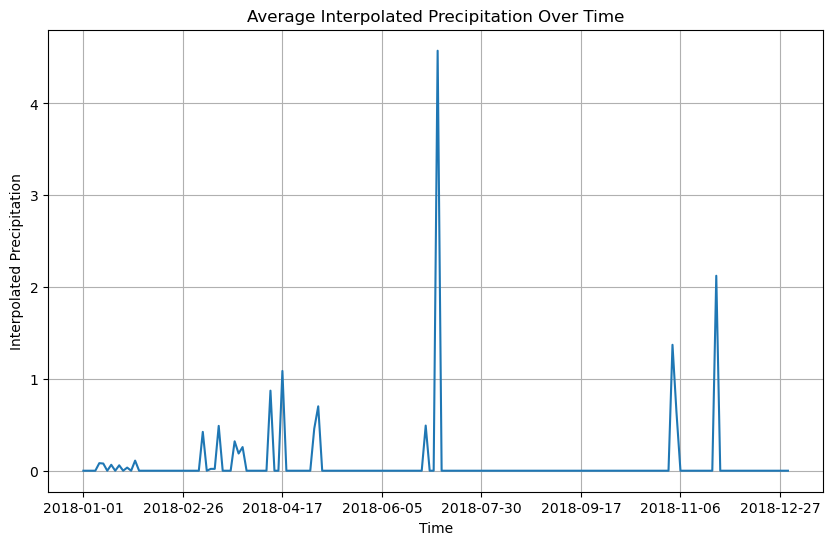

In [6]:
test_df = CHIRPS_df[(CHIRPS_df['lat'] == CHIRPS_df['lat'][0]) & (CHIRPS_df['lon'] == CHIRPS_df['lon'][0])]
# Group by time and calculate the mean interpolated_precip
mean_precip = test_df.groupby('time')['interpolated_precip'].mean()

# Plotting
plt.figure(figsize=(10, 6))
mean_precip.plot()
plt.title('Average Interpolated Precipitation Over Time')
plt.xlabel('Time')
plt.ylabel('Interpolated Precipitation')
plt.grid(True)
plt.show()

In [7]:
def get_pulsing_level(precip):
    if precip < 1:
        return 'No Pulse'
    elif precip < 5:
        return 'Sprinkle'
    elif precip < 15:
        return 'Shower'
    else:
        return 'Heavy rain'
    
# Decide the Pulsing Level {'No Pulse', 'Sprinkle', 'Shower', 'Heavy rain'} based on interpolated precip
# Decide the Pulsing Day based on the time [Missing Dates are handled]
#    e.g. 5/1 --> Day 1 of Shower, 5/2 --> Missing Date [not included], 5/3 --> Day 3 of Shower
# Prioritize the Pulsing Event of the Beginning Day
#    e.g. 5/1 --> Day 1 of Shower, 5/6 --> Day 1 of Sprinkle & Day 6 of Shower, display as Day 1 of Sprinkle

def pulsing_func(df):
    # Convert the 'time' column to datetime objects
    df = df.sort_values('time')
    df['time'] = pd.to_datetime(df['time'])
    df = df.reset_index()

    # Apply the function to determine the initial pulsing level
    df['Pulsing Level'] = df['interpolated_precip'].apply(get_pulsing_level)
    
    # Initialize the Pulsing Day column
    df['Pulsing Day'] = 0

    # Iterate over the DataFrame and update the Pulsing Day
    for i, row in df.iterrows():
        pulsing_level = row['Pulsing Level']
        current_date = row['time']
        
        if pulsing_level == 'Sprinkle':
            end_date = current_date + pd.Timedelta(days=2)
        elif pulsing_level == 'Shower':
            end_date = current_date + pd.Timedelta(days=6)
        elif pulsing_level == 'Heavy rain':
            end_date = current_date + pd.Timedelta(days=13)
        else:
            continue  # No Pulse, skip to the next row

        # Update Pulsing Day for the current and following days
        date_range = pd.date_range(start=current_date, end=end_date)
        for pulsing_day, date in enumerate(date_range, start=1):
            if date in df['time'].values:
                df.loc[(df['lat'] == row['lat']) & (df['lon'] == row['lon']) & (df['time'] == date), 'Pulsing Level'] = pulsing_level
                df.loc[(df['lat'] == row['lat']) & (df['lon'] == row['lon']) & (df['time'] == date), 'Pulsing Day'] = pulsing_day

    return df

def Pulsing_Factor_Func(Pulsing_Level, t):
    if Pulsing_Level == 'No Pulse':
        return 1
    if Pulsing_Level == 'Sprinkle':
        return 11.19 * np.exp(-0.805 * t) # t = 1-3
    if Pulsing_Level == 'Shower':
        return 14.68 * np.exp(-0.384 * t) # t = 1-7
    if Pulsing_Level == 'Heavy rain':
        return 18.46 * np.exp(-0.208 * t) # t = 1-14
    else:
        return 1
        


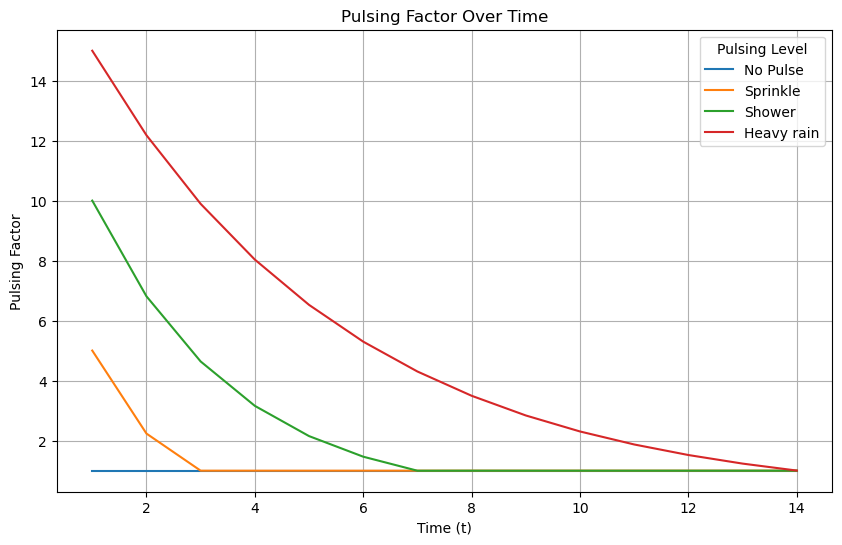

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def Pulsing_Factor_Func(Pulsing_Level, t):
    if Pulsing_Level == 'No Pulse':
        return 1
    elif Pulsing_Level == 'Sprinkle':
        if t > 3:
            return 1
        else:
            return 11.19 * np.exp(-0.805 * t)  # t = 1-3
    elif Pulsing_Level == 'Shower':
        if t > 7:
            return 1
        else:
            return 14.68 * np.exp(-0.384 * t)  # t = 1-7
    elif Pulsing_Level == 'Heavy rain':
        return 18.46 * np.exp(-0.208 * t)  # t = 1-14
    else:
        return 1

# Define the time range from 1 to 14
t = np.arange(1, 15)

# Define the pulsing levels
pulsing_levels = ['No Pulse', 'Sprinkle', 'Shower', 'Heavy rain']

# Setup the plot
plt.figure(figsize=(10, 6))

# Loop through each pulsing level and plot
for level in pulsing_levels:
    pulsing_factor = [Pulsing_Factor_Func(level, time) for time in t]
    plt.plot(t, pulsing_factor, label=level)

# Add plot formatting
plt.title('Pulsing Factor Over Time')
plt.xlabel('Time (t)')
plt.ylabel('Pulsing Factor')
plt.legend(title='Pulsing Level')
plt.grid(True)
plt.show()



In [8]:
test_df = CHIRPS_df[(CHIRPS_df['lat']== CHIRPS_df['lat'][0]) & (CHIRPS_df['lon']== CHIRPS_df['lon'][0])].reset_index()

test_df = pulsing_func(test_df)
test_df[['interpolated_precip', 'time', 'Pulsing Level', 'Pulsing Day', ]].loc[80:100]

,interpolated_precip,time,Pulsing Level,Pulsing Day
80,0.000000,2018-06-15,No Pulse,0
81,0.000000,2018-06-18,No Pulse,0
82,0.000000,2018-06-20,No Pulse,0
83,0.000000,2018-06-21,No Pulse,0
84,0.000000,2018-06-23,No Pulse,0
85,0.000000,2018-06-26,No Pulse,0
86,0.491781,2018-06-29,No Pulse,0
87,0.000000,2018-07-01,No Pulse,0
88,0.000000,2018-07-04,No Pulse,0
89,4.574133,2018-07-06,Sprinkle,1


# Calculate the Pulsing Effect Scaling Factor

In [9]:
# CHIRPS_df = CHIRPS_df.drop_duplicates()

In [10]:
from tqdm import tqdm

CHIRPS_df = CHIRPS_df
df = pd.DataFrame()

lats = set(CHIRPS_df['lat'])
lons = set(CHIRPS_df['lon'])

lats = list(lats)
lats.sort()

lons = list(lons)
lons.sort()


print(min(lats), max(lats), min(lons), max(lons))
print('processing China with Lower Lat and Lower Lon')

18.04800033569336 53.89459991455078 73.05497741699219 134.9533233642578
processing China with Lower Lat and Lower Lon


In [11]:
# Assume lats is a list or a set of latitudes, and we convert it to a list if it's a set
lats = list(lats)  # Ensure it's a list to support indexing

# Determine the number of latitudes per chunk
total_count = len(lats)
chunk_size = round(total_count / 24)

lats_list = [lats[i * chunk_size:(i + 1) * chunk_size] for i in range(24)]

# If the total count is not perfectly divisible by 24, add the remaining latitudes to the last chunk
if total_count % 24:
    lats_list[-1].extend(lats[24 * chunk_size:])



In [12]:
lats

[18.04800033569336,
 18.12218475341797,
 18.196399688720703,
 18.270647048950195,
 18.34492301940918,
 18.41923141479492,
 18.493572235107425,
 18.567943572998047,
 18.6423454284668,
 18.716781616210938,
 18.791248321533203,
 18.865747451782227,
 18.94027709960937,
 19.01484107971192,
 19.08943748474121,
 19.1640682220459,
 19.23872947692871,
 19.31342506408692,
 19.388153076171875,
 19.462915420532227,
 19.53771209716797,
 19.61254119873047,
 19.68740463256836,
 19.76230239868164,
 19.837234497070312,
 19.91220092773437,
 19.98720359802246,
 20.062238693237305,
 20.13731002807617,
 20.212417602539062,
 20.287559509277344,
 20.36273765563965,
 20.437950134277344,
 20.51320075988769,
 20.58848571777344,
 20.663806915283203,
 20.739166259765625,
 20.81455993652344,
 20.889991760253903,
 20.96546173095703,
 21.04096794128418,
 21.11651039123535,
 21.19209098815918,
 21.267709732055664,
 21.343366622924805,
 21.4190616607666,
 21.49479484558105,
 21.570566177368164,
 21.64637756347656,
 21

In [13]:
for index in np.arange(23, 24):
    lats = lats_list[index]
    
    total_iterations = len(lats) * len(lons)
    progress_bar = tqdm(total=total_iterations, desc="Processing")

    for lat in lats:
        for lon in lons:
            # Update progress bar
            progress_bar.update(1)

            test_df = CHIRPS_df[(CHIRPS_df['lat'] == lat) & (CHIRPS_df['lon'] == lon)]

            test_df = pulsing_func(test_df)
            test_df['Factor B Pulsing Effect'] = test_df.apply(lambda row: Pulsing_Factor_Func(row['Pulsing Level'], row['Pulsing Day']), axis = 1)


            df = pd.concat([test_df, df])

    # Close the progress bar
    progress_bar.close()

    df.to_csv(f'/global/scratch/users/liuwenjin021011/data/ThesisFactorB/FactorB_DONE_Year_2018_lats_chunk{index}.csv')

Processing: 100%|██████████| 10624/10624 [7:43:37<00:00,  2.62s/it] 


In [14]:
files = []
path = '/global/scratch/users/liuwenjin021011/data/ThesisFactorB/'
for file in os.listdir(path):
    if 'FactorB_DONE_Year_2018' in file:
        files += [path + file]

In [15]:
def merge_file(file_list, save_name):
    all_df = pd.DataFrame()
    for file in file_list:
        chunk_df = pd.read_csv(file)
        all_df = pd.concat([all_df, chunk_df])
        
    all_df = all_df.drop(columns = ['Unnamed: 0'])
    all_df = all_df.drop_duplicates()
    all_df.to_csv(f'/global/scratch/users/liuwenjin021011/data/FactorB_DONE_Year_{save_name}.csv')

In [16]:
merge_file(files, '2018')

/tmp/ipykernel_165554/2440570627.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(file)


# Visualization

In [2]:
df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorB_DONE_Year_2017.csv')

df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorB_DONE_Year_2018.csv')

df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorB_DONE_Year_2019.csv')

/tmp/ipykernel_10304/3041005326.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorB_DONE_Year_2018.csv')
/tmp/ipykernel_10304/3041005326.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/FactorB_DONE_Year_2019.csv')


/tmp/ipykernel_10304/1630463797.py:49: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_Biome_Fitting_within_shape(df_2017, 2017, shapefile_path, column='Factor B Pulsing Effect')


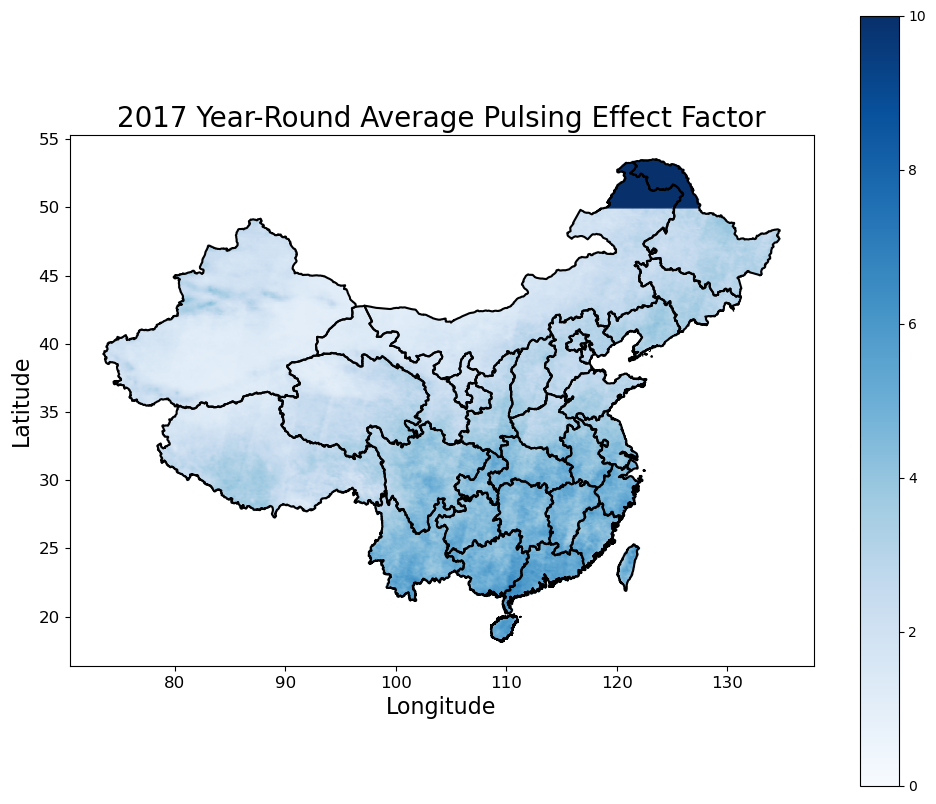

/tmp/ipykernel_10304/1630463797.py:50: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_Biome_Fitting_within_shape(df_2018, 2018, shapefile_path, column='Factor B Pulsing Effect')


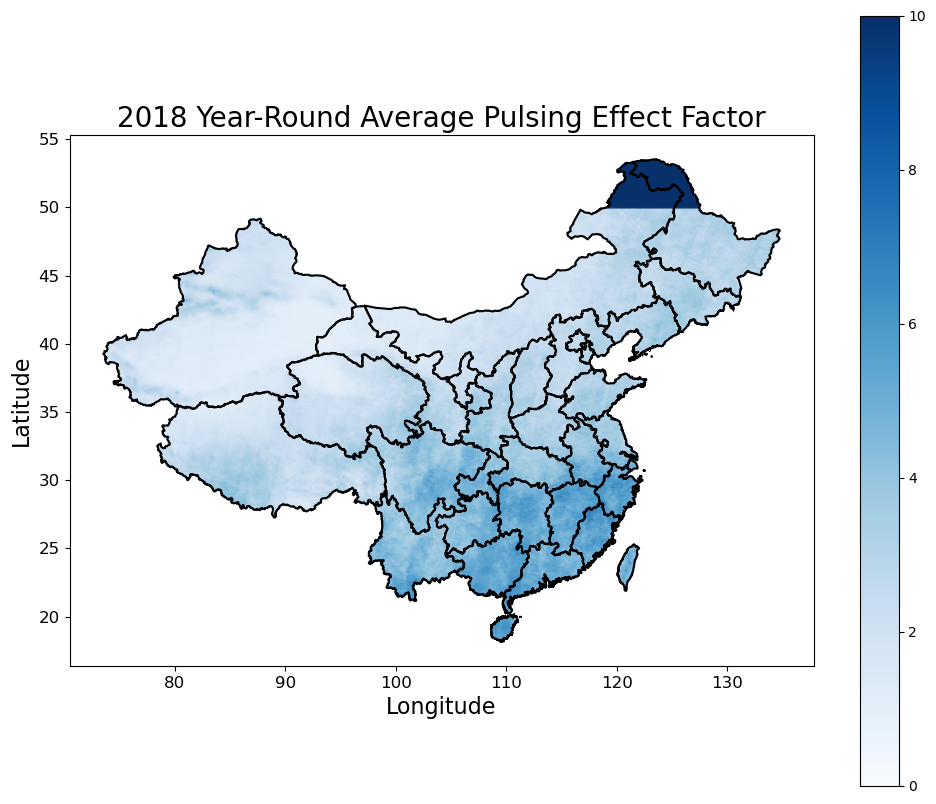

/tmp/ipykernel_10304/1630463797.py:51: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  plot_Biome_Fitting_within_shape(df_2019, 2019, shapefile_path, column='Factor B Pulsing Effect')


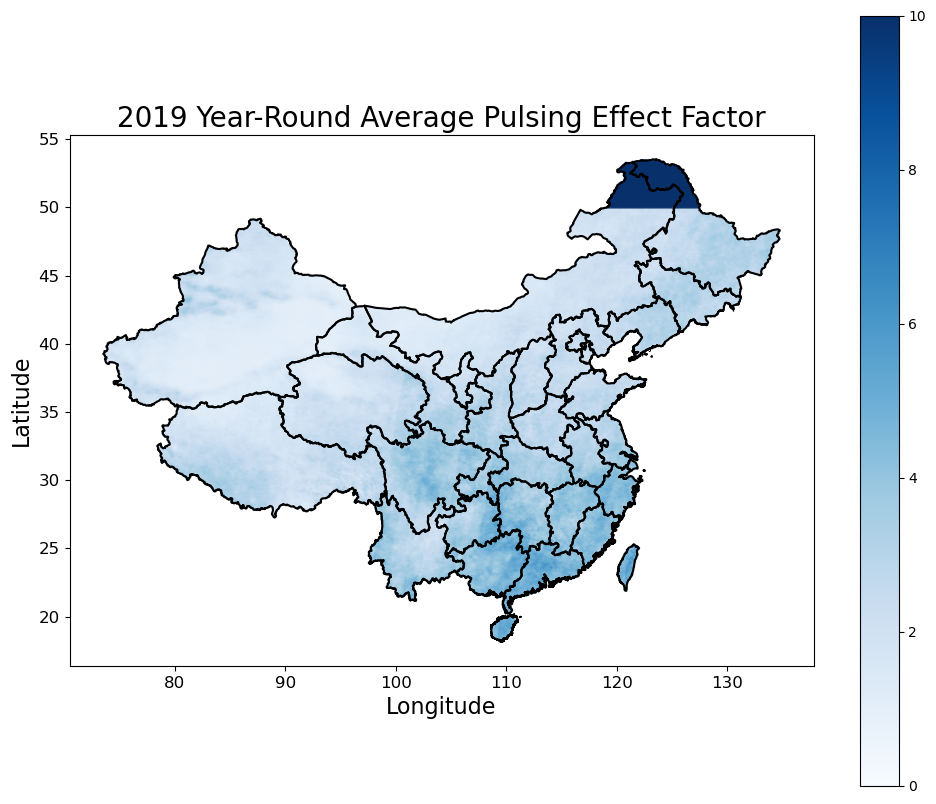

In [3]:
def filter_points_within_shape(df, shapefile_path, column):
    # Compute the average of the column of interest
    avg_df = df.groupby(['lat', 'lon'])[column].mean().reset_index()
    avg_df.rename(columns={column: f'avg_{column}'}, inplace=True)

    # Convert df to a GeoDataFrame
    gdf = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.lon, avg_df.lat))

    # Set the coordinate reference system (CRS)
    gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84, adjust as necessary

    # Load the shapefile
    base_map = gpd.read_file(shapefile_path)
    base_map.set_crs(epsg=4326, inplace=True)

    # Perform spatial join to keep only points within the shapefile boundaries
    gdf_within_shape = gpd.sjoin(gdf, base_map, how="inner", op='intersects')

    # Drop the 'index_right' column if exists
    if 'index_right' in gdf_within_shape.columns:
        gdf_within_shape.drop(columns=['index_right'], inplace=True)

    return gdf_within_shape, base_map

def plot_Biome_Fitting_within_shape(df, year, shapefile_path, column='Factor B Pulsing Effect', vmin=0, vmax=10):
    # Filter points to keep only those within the shapefile
    filtered_df, base_map = filter_points_within_shape(df, shapefile_path, column)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    base_map.plot(ax=ax, color='white', edgecolor='black', alpha=0)  # Plot the base map first with no fill color
    filtered_df.plot(ax=ax, column=f'avg_{column}', cmap='Blues', legend=True, markersize=2, alpha=0.5, vmin=vmin, vmax=vmax)  # Then plot the data points
    base_map.boundary.plot(ax=ax, edgecolor='black')  # Plot the boundaries on top

    
    title= f'{year} Year-Round Average Pulsing Effect Factor'
    plt.title(title, fontsize=20)
        
    plt.xlabel('Longitude', fontsize=16)  # Larger font size for the x-axis label
    plt.ylabel('Latitude', fontsize=16)  # Larger font size for the y-axis label
    plt.xticks(fontsize=12)  # Larger font size for the x-axis ticks
    plt.yticks(fontsize=12)  # Larger font size for the y-axis ticks

    plt.show()
    

# Usage
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'
plot_Biome_Fitting_within_shape(df_2017, 2017, shapefile_path, column='Factor B Pulsing Effect')
plot_Biome_Fitting_within_shape(df_2018, 2018, shapefile_path, column='Factor B Pulsing Effect')
plot_Biome_Fitting_within_shape(df_2019, 2019, shapefile_path, column='Factor B Pulsing Effect')